In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
import pytorch_lightning as pl
from pathlib import Path
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
DATA_DIR = Path('/kaggle/input/solvro-rekrutacja-zimowa-ml-2023')
WRITING_DIR = Path('/kaggle/working/')
SUBDATA_DIR = Path('/kaggle/working/input_subdata')

os.makedirs(SUBDATA_DIR, exist_ok=True)

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/solvro-rekrutacja-zimowa-ml-2023/sample_submission.csv
/kaggle/input/solvro-rekrutacja-zimowa-ml-2023/y_train.npy
/kaggle/input/solvro-rekrutacja-zimowa-ml-2023/y_val.npy
/kaggle/input/solvro-rekrutacja-zimowa-ml-2023/X_test.npy
/kaggle/input/solvro-rekrutacja-zimowa-ml-2023/X_val.npy
/kaggle/input/solvro-rekrutacja-zimowa-ml-2023/X_train.npy


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
CLASS_LABELS = np.array([chr(label + ord('A')) for label in range(26)])
IMG_SIZE = (28, 28)

In [4]:
from pathlib import Path
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
def id_2_label(idx):
    return CLASS_LABELS[idx]


def label_2_id(label):
    return ord(label) - ord('A')


def oneh_2_label(one_hot_id):
    return CLASS_LABELS[one_hot_id.argmax(axis=-1)]


def label_2_1hot(label):
    arr = np.zeros(len(CLASS_LABELS))
    arr[label_2_id(label)] = 1
    return arr


def get_classes_count(y_true):
    class_labels = oneh_2_label(y_true)
    return pd.Series(class_labels).value_counts()


def split_save(X, y, test_size=0.25, stratify=None, writing_dir=Path("../data/input_data")):

    X_subval, X_subtest, y_subval, y_subtest = train_test_split(X, y, stratify=stratify,
                                              test_size=test_size, random_state=42)

    np.save(writing_dir / 'X_subval.npy', X_subval)
    np.save(writing_dir / 'y_subval.npy', y_subval)
    np.save(writing_dir / 'X_subtest.npy', X_subtest)
    np.save(writing_dir / 'y_subtest.npy', y_subtest)


def plot_letters(images, label_ids, n_rows=3, n_cols=3):
    plt.figure(figsize=(8, 8), constrained_layout=True)
    for i, (img, label_id) in enumerate(zip(images, label_ids)):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img, cmap='Greys')
        plt.title(oneh_2_label(label_id))

In [5]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class HandwritingsDataset(Dataset):

    def __init__(self, X_file_path, y_file_path,
                 sample_transform=None, data_transform=None):
        self.X_file_path = X_file_path
        self.y_file_path = y_file_path
        self.sample_transform = sample_transform

        self.X_data = np.load(X_file_path)

        y_data = np.load(y_file_path) if self.y_file_path else np.ones((len(self.X_data), 1))

        if data_transform:
            self.X_data = data_transform(self.X_data)

        self.y_labels = y_data.argmax(axis=-1)
        self.X_data = torch.from_numpy(self.X_data).to(torch.float32)

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, index):
        # Here we could load this lazily
        if self.sample_transform:
            return self.sample_transform([self.X_data[index], self.y_labels[index]])
        return self.X_data[index], self.y_labels[index]


class HandwritingsBalancedDataset(HandwritingsDataset):

    def __init__(self, sampling_algorithm, **kwargs):
        super().__init__(**kwargs)
        self.sampling_algorithm = sampling_algorithm
        self.transform_X_y()

    def transform_X_y(self):

        # Data for the resampler should be in format (n_samples, n_features)
        X = self.X_data.reshape(self.X_data.shape[0], -1)
        X, self.y_labels = self.sampling_algorithm.fit_resample(X, self.y_labels)
        self.X_data = X.reshape(-1, *IMG_SIZE)
        # Back to torch tensors 
        self.X_data = torch.from_numpy(self.X_data).to(torch.float32)

In [6]:
from torchvision import transforms
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomPerspective, RandomRotation, RandomResizedCrop
import torch 

image_transform = transforms.Compose(
    [RandomHorizontalFlip(p=0.25),
    RandomVerticalFlip(p=0.25),
    RandomResizedCrop((28, 28), scale=(0.8,1.0), ratio=(0.9,1.1), antialias=True),
    RandomPerspective(distortion_scale=0.5, p=0.25, fill=0),
    RandomRotation(degrees=45)]
)

class ImgTransform:

    def __init__(self, img_transform, color_channel=False):
        self.img_transform = img_transform
        self.color_channel = color_channel

    def __call__(self, sample):
        x, y = sample
        x = x.reshape(1, *IMG_SIZE) # add color channel
        if not self.color_channel:
            x = self.img_transform(x).reshape(*IMG_SIZE) # remove color channel
        return x, y
    

def visualize_img_transform(sample_img, label, transform):
    img_tensor = torch.from_numpy(sample_img.reshape(1, *IMG_SIZE))
    plt.title(label)
    plt.imshow(transform(img_tensor).reshape(*IMG_SIZE), cmap='Greys')

class Reshape(object):
    
    def __init__(self, shape=(-1, )):
        self.shape = shape
    
    def __call__(self, sample):
        x, y = sample 
        return x.reshape(self.shape), y

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, f1_score, precision_recall_fscore_support


def min_f1_score(y_true, y_pred):
    f1_score_by_class = f1_score(y_true, y_pred, average=None)
    return f1_score_by_class.min()


def get_classification_report(y_true, y_pred):
    precision, recall, f1score, support = precision_recall_fscore_support(y_true, y_pred)
    clf_report_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1score, 'support': support},
                                 index=id_2_label(np.arange(len(CLASS_LABELS))))

    return clf_report_df

In [8]:
import torch
import torch.nn as nn
import torchmetrics 
import torch.nn.functional as F
import pytorch_lightning as pl

class BaseFNN(pl.LightningModule):

    def __init__(self, n_classes, class_weights=None):
        super().__init__()

        self.n_classes = n_classes
        self.train_f1_score = torchmetrics.classification.MulticlassF1Score(num_classes=n_classes)
        self.val_f1_score = torchmetrics.classification.MulticlassF1Score(num_classes=n_classes)
        self.class_weights = class_weights

    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)
        loss = F.cross_entropy(predictions, y, weight=self.class_weights)
        predicted_labels = torch.argmax(predictions, axis=-1)
        self.log('train_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        self.log('train_f1_score', self.train_f1_score, on_epoch=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)
        loss = F.cross_entropy(predictions, y)
        predicted_labels = torch.argmax(predictions, axis=-1)
        self.log('val_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        self.log('val_f1_score', self.val_f1_score, on_epoch=True)
        return {'val_loss': loss}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        predictions = self(x)
        predicted_labels = torch.argmax(predictions, axis=-1)
        return predicted_labels

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    
class FNN(BaseFNN):
    
    def __init__(self, input_size, hidden_sizes, class_weights=None, act_fn=F.relu, **kwargs):
        super().__init__(**kwargs)

        self.act_fn = act_fn

        layers = [nn.Linear(input_size, hidden_sizes[0])]
        layers += [nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]) for i in range(len(hidden_sizes) - 1)]

        layers += [nn.Linear(hidden_sizes[-1], n_classes)]

        self.linears = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for fc in self.linears[:-1]:
            x = self.act_fn(fc(x))
        x = self.linears[-1](x)
        return x

In [9]:
X_val = np.load(DATA_DIR / 'X_val.npy')
y_val = np.load(DATA_DIR / 'y_val.npy')
split_save(X_val, y_val, stratify=y_val, writing_dir=SUBDATA_DIR)

y_train = np.load(DATA_DIR / 'y_train.npy')

y_true = np.load(SUBDATA_DIR / 'y_subtest.npy')
y_true_labels = y_true.argmax(axis=-1)

subtest_labels = np.load(SUBDATA_DIR / 'y_subtest.npy').argmax(axis=-1)

In [179]:
batch_size = 32
max_epochs = 30
input_size = 784
n_classes=len(CLASS_LABELS)
hidden_sizes = [512, 256, 256, 128]

In [175]:
X_train = np.load(DATA_DIR / 'X_train.npy')

X_mean = X_train.mean()
X_std = X_train.std()

def normalize(X):
    return (X - X_mean) / X_std

In [176]:
train_dataset = HandwritingsDataset(X_file_path=DATA_DIR / 'X_train.npy', y_file_path=DATA_DIR / 'y_train.npy',
                                             data_transform=normalize)

train_loader = DataLoader(train_dataset, num_workers=4,
                         batch_size=batch_size, shuffle=True)


val_dataset = HandwritingsDataset(SUBDATA_DIR / 'X_subval.npy', SUBDATA_DIR / 'y_subval.npy',
                                             data_transform=normalize)

val_loader = DataLoader(val_dataset, num_workers=4,
                                batch_size=batch_size, shuffle=False)

test_dataset = HandwritingsDataset(SUBDATA_DIR / 'X_subtest.npy', SUBDATA_DIR / 'y_subtest.npy',
                                             data_transform=normalize)

test_loader = DataLoader(test_dataset, num_workers=4,
                                batch_size=batch_size, shuffle=False)

In [160]:
fnn_checkpoint_dir = WRITING_DIR / 'fnn_4_layers'

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=fnn_checkpoint_dir / 'best_results', filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

fnn = FNN(input_size=input_size, n_classes=n_classes, hidden_sizes=hidden_sizes)

trainer = pl.Trainer(max_epochs=max_epochs, default_root_dir=fnn_checkpoint_dir, fast_dev_run=True,
                     callbacks=[early_stopping, checkpoint_callback])

trainer.fit(fnn, train_loader, val_loader)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [161]:
os.listdir(fnn_checkpoint_dir / 'best_results')

['last.ckpt', 'epoch=6-val_loss=0.17-train_loss=0.10.ckpt']

In [162]:
fnn_checkpoint_dir = WRITING_DIR / 'fnn_4_layers'
fnn = FNN.load_from_checkpoint(fnn_checkpoint_dir / 'best_results/epoch=6-val_loss=0.17-train_loss=0.10.ckpt', input_size=input_size,
                               n_classes=n_classes, hidden_sizes=hidden_sizes)

trainer = pl.Trainer()
predictions = trainer.predict(fnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

Predicting: 0it [00:00, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       320
           1       0.98      0.94      0.96       194
           2       0.96      0.99      0.97       505
           3       0.92      0.84      0.88       228
           4       0.94      0.97      0.95       247
           5       0.98      0.95      0.96       459
           6       0.95      0.97      0.96       126
           7       0.95      0.92      0.94       158
           8       0.97      0.98      0.98       597
           9       0.96      0.94      0.95       188
          10       0.92      0.92      0.92       123
          11       0.97      0.95      0.96       254
          12       0.98      0.98      0.98       450
          13       0.97      0.97      0.97       412
          14       0.96      0.99      0.98      1249
          15       0.96      0.98      0.97       417
          16       0.96      0.95      0.96       130
          17       0.94    

In [163]:
fnn_checkpoint_dir = WRITING_DIR / 'fnn_4_layers'
fnn = FNN.load_from_checkpoint(fnn_checkpoint_dir / 'best_results/epoch=6-val_loss=0.17-train_loss=0.10.ckpt', input_size=input_size,
                               n_classes=n_classes, hidden_sizes=hidden_sizes)
torch.save(fnn.state_dict(), 'fnn_4_layers_model')

In [89]:
report = get_classification_report(subtest_labels, torch.cat(predictions).numpy())
report = report.rename(columns={'f1_score': 'f1_score_baseline'})
report = report.drop(['precision', 'recall'], axis=1)
report.sort_values(by=['f1_score_baseline'])

,f1_score_baseline,support
D,0.880734,228
K,0.918699,123
V,0.922414,232
H,0.938907,158
J,0.948787,188
U,0.951004,630
R,0.951456,254
W,0.952586,235
E,0.954092,247
Q,0.957529,130


In [90]:
y_train = np.load(DATA_DIR / 'y_train.npy')
train_class_count = get_classes_count(y_train)
train_class_prob = train_class_count / train_class_count.sum()
train_class_prob

O    0.132212
S    0.109886
U    0.066688
I    0.063222
C    0.053418
T    0.051969
F    0.048589
M    0.047636
P    0.044177
N    0.043594
A    0.033910
L    0.026865
R    0.026845
E    0.026110
Y    0.025098
W    0.024847
V    0.024543
D    0.024146
B    0.020520
J    0.019912
H    0.016684
X    0.014666
Z    0.014296
Q    0.013786
G    0.013323
K    0.013058
Name: count, dtype: float64

In [91]:
report['train_class_prob'] = train_class_prob

#### How imbalance affect predictions? 
Summary below gives an overview of how many minority classes have worse predictions than average and the same for the majority classes. However, it looks like the problem doesn't have a big scale (around 0.04 percentage points). However, it's worthy to check out whether class weighning could improve results. 

In [92]:
y_train = np.load(DATA_DIR / 'y_train.npy')
train_class_count = get_classes_count(y_train)
train_class_prob = train_class_count / train_class_count.sum()

def print_summary(report, f1_score_column):
    mean_f1_baseline = report[f1_score_column].mean()
    print(f"Mean f1 score [{f1_score_column}] = {mean_f1_baseline:.3f}")

    mean_train_prob = report['train_class_prob'].mean()
    print(f"Mean train class prob = {mean_train_prob:.3f}")

    f1_baseline_below_mean = report[report[f1_score_column] < mean_f1_baseline]
    class_prob_below_mean = report[report['train_class_prob'] < mean_train_prob]

    print("Classes with f1 score BELOW mean\n", f1_baseline_below_mean[[f1_score_column, 'train_class_prob']])
    print("Classes with probability BELOW mean\n", class_prob_below_mean[[f1_score_column, 'train_class_prob']])

    min_labels_below_mean = set(f1_baseline_below_mean.index) & set(class_prob_below_mean.index)

    print(min_labels_below_mean)
    print("What percentage of minority classes have scores below mean", f"{(len(min_labels_below_mean) / len(set(class_prob_below_mean.index))):.3f}")

    class_prob_above_mean = report[report['train_class_prob'] >= mean_train_prob]

    maj_labels_above_mean = set(f1_baseline_below_mean.index) & set(class_prob_above_mean.index)

    print(maj_labels_above_mean)
    print("What percentage of majority classes have scores below mean", f"{(len(maj_labels_above_mean) / len(set(class_prob_above_mean.index))):.3f}")

print_summary(report, 'f1_score_baseline')

Mean f1 score [f1_score_baseline] = 0.958
Mean train class prob = 0.038
Classes with f1 score BELOW mean
    f1_score_baseline  train_class_prob
D           0.880734          0.024146
E           0.954092          0.026110
H           0.938907          0.016684
J           0.948787          0.019912
K           0.918699          0.013058
Q           0.957529          0.013786
R           0.951456          0.026845
U           0.951004          0.066688
V           0.922414          0.024543
W           0.952586          0.024847
Classes with probability BELOW mean
    f1_score_baseline  train_class_prob
A           0.973312          0.033910
B           0.960422          0.020520
D           0.880734          0.024146
E           0.954092          0.026110
G           0.960630          0.013323
H           0.938907          0.016684
J           0.948787          0.019912
K           0.918699          0.013058
L           0.962227          0.026865
Q           0.957529          0.013786

In [94]:
def plot_distributions(report, *f1_score_columns):
    plt.figure(figsize=(7, 7))
    sorted_class_labels = report.sort_index().index
    sns.barplot(data=report[['train_class_prob', *f1_score_columns]].reset_index().melt(value_vars=['train_class_prob', *f1_score_columns], id_vars=['index']), y='value',
               x='index', order=sorted_class_labels, hue='variable')
    plt.ylabel('Value')
    plt.xlabel('Letter')
    _ = plt.title('Distribution of class prob and f1')

def plot_f1_vs_class_prob(report, *f1_score_columns):
    plt.figure(figsize=(7, 7))
    sns.relplot(report[['train_class_prob', *f1_score_columns]].melt(value_vars=f1_score_columns, id_vars=['train_class_prob']), y='train_class_prob',
               x='value', hue='variable')
    plt.ylabel('Class probability')
    plt.xlabel('F1 score')
    _ = plt.title('Distribution of class prob and f1')

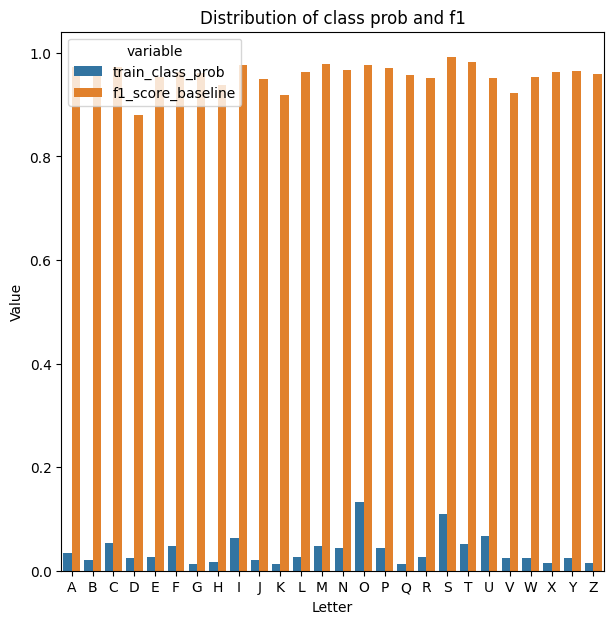

In [95]:
plot_distributions(report, 'f1_score_baseline')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 700x700 with 0 Axes>

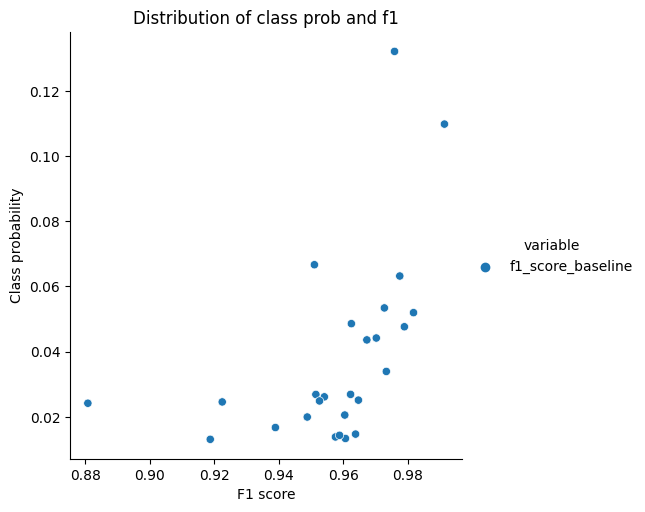

In [96]:
plot_f1_vs_class_prob(report, 'f1_score_baseline')

### Train with classes weights 

Class weights are inversely proportional to the class probabilities

In [167]:
y_train = np.load(DATA_DIR / 'y_train.npy')
classes_count = get_classes_count(y_train)
class_share = classes_count / sum(classes_count)
class_weights = 1 / (class_share * 100)
class_weights = class_weights.sort_index()
class_weights = torch.tensor(class_weights).to(device).type(torch.float32)

In [168]:
fnn_checkpoint_dir = WRITING_DIR / 'fnn_weighted_4_layers'

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=fnn_checkpoint_dir / 'best_results', filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True)

early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

fnn = FNN(input_size=input_size, n_classes=n_classes, hidden_sizes=hidden_sizes, class_weights=class_weights)

trainer = pl.Trainer(max_epochs=max_epochs, default_root_dir=fnn_checkpoint_dir, fast_dev_run=True,
                     callbacks=[early_stopping, checkpoint_callback])

trainer.fit(fnn, train_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /kaggle/working/fnn_weighted_4_layers/best_results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassF1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [100]:
os.listdir(fnn_checkpoint_dir / 'best_results')

['last.ckpt',
 'epoch=4-val_loss=0.22-train_loss=0.18.ckpt',
 'last-v2.ckpt',
 'epoch=4-val_loss=0.17-train_loss=0.12.ckpt',
 'last-v1.ckpt',
 'epoch=2-val_loss=0.23-train_loss=0.22.ckpt']

In [101]:
fnn_checkpoint_dir = WRITING_DIR / 'fnn_weighted_4_layers'
fnn = FNN.load_from_checkpoint(fnn_checkpoint_dir / 'best_results/epoch=4-val_loss=0.17-train_loss=0.12.ckpt', input_size=input_size,
                               n_classes=n_classes, hidden_sizes=hidden_sizes)

trainer = pl.Trainer()
predictions = trainer.predict(fnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

Predicting: 0it [00:00, ?it/s]

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       320
           1       0.92      0.94      0.93       194
           2       0.94      0.98      0.96       505
           3       0.91      0.79      0.85       228
           4       0.98      0.92      0.95       247
           5       0.96      0.95      0.96       459
           6       0.92      0.96      0.94       126
           7       0.89      0.94      0.91       158
           8       0.95      0.98      0.97       597
           9       0.97      0.93      0.95       188
          10       0.95      0.87      0.91       123
          11       0.96      0.96      0.96       254
          12       0.98      0.98      0.98       450
          13       0.97      0.94      0.95       412
          14       0.97      0.97      0.97      1249
          15       0.94      0.97      0.95       417
          16       0.98      0.91      0.94       130
          17       0.94    

In [169]:
fnn_checkpoint_dir = WRITING_DIR / 'fnn_weighted_4_layers'
fnn = FNN.load_from_checkpoint(fnn_checkpoint_dir / 'best_results/epoch=4-val_loss=0.17-train_loss=0.12.ckpt', input_size=input_size,
                               n_classes=n_classes, hidden_sizes=hidden_sizes)
torch.save(fnn, 'fnn_weighted_4_layers_model')

In [102]:
clf_report_class_weights = get_classification_report(subtest_labels, torch.cat(predictions).numpy())
report['f1_score_weighted'] = clf_report_class_weights['f1_score']

The minimum score is worse 

In [103]:
report['f1_score_weighted'].min()

0.8457943925233644

In [104]:
print_summary(report, 'f1_score_weighted')

Mean f1 score [f1_score_weighted] = 0.945
Mean train class prob = 0.038
Classes with f1 score BELOW mean
    f1_score_weighted  train_class_prob
B           0.931298          0.020520
D           0.845794          0.024146
G           0.937984          0.013323
H           0.914110          0.016684
K           0.906780          0.013058
Q           0.940239          0.013786
V           0.902808          0.024543
W           0.944915          0.024847
X           0.943262          0.014666
Y           0.928870          0.025098
Classes with probability BELOW mean
    f1_score_weighted  train_class_prob
A           0.952381          0.033910
B           0.931298          0.020520
D           0.845794          0.024146
E           0.951983          0.026110
G           0.937984          0.013323
H           0.914110          0.016684
J           0.945652          0.019912
K           0.906780          0.013058
L           0.960474          0.026865
Q           0.940239          0.013786

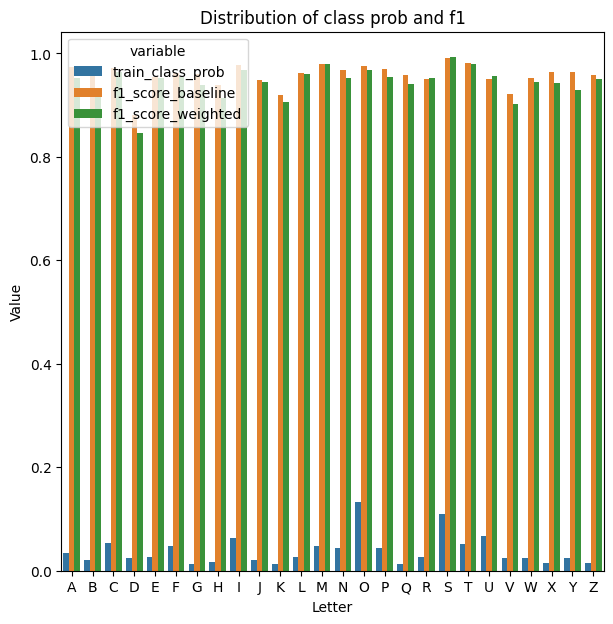

In [105]:
plot_distributions(report, 'f1_score_baseline', 'f1_score_weighted')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 700x700 with 0 Axes>

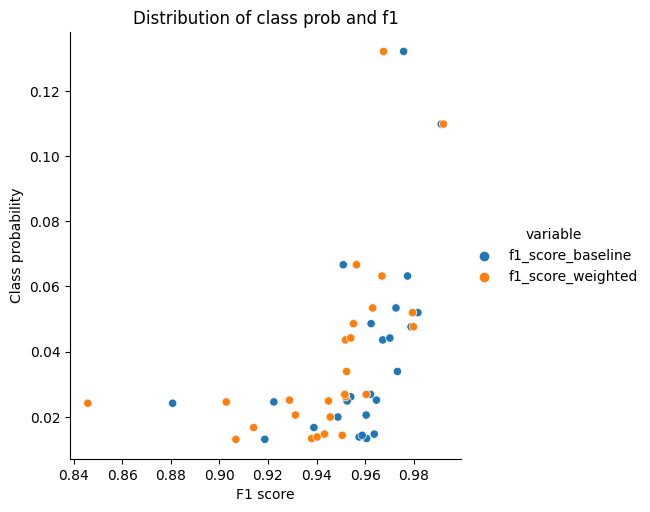

In [106]:
plot_f1_vs_class_prob(report, 'f1_score_baseline', 'f1_score_weighted')

### Increase network size 

In [181]:
batch_size = 32
max_epochs = 30
input_size = 784
n_classes=len(CLASS_LABELS)
hidden_sizes = [512, 512, 256, 256, 128]

In [171]:
fnn_checkpoint_dir = WRITING_DIR / 'fnn_5_layers'

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=fnn_checkpoint_dir / 'best_results', filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

fnn = FNN(input_size=input_size, n_classes=n_classes, hidden_sizes=hidden_sizes)

trainer = pl.Trainer(max_epochs=max_epochs, default_root_dir=fnn_checkpoint_dir, fast_dev_run=True,
                     callbacks=[early_stopping, checkpoint_callback])

trainer.fit(fnn, train_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /kaggle/working/fnn_5_layers/best_results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [110]:
os.listdir(fnn_checkpoint_dir / 'best_results')

['last.ckpt',
 'epoch=4-val_loss=0.20-train_loss=0.14.ckpt',
 'epoch=4-val_loss=0.16-train_loss=0.13.ckpt',
 'last-v1.ckpt']

In [111]:
fnn_checkpoint_dir = WRITING_DIR / 'fnn_5_layers'
fnn = FNN.load_from_checkpoint(fnn_checkpoint_dir / 'best_results/epoch=4-val_loss=0.16-train_loss=0.13.ckpt', input_size=input_size,
                               n_classes=n_classes, hidden_sizes=hidden_sizes)

trainer = pl.Trainer()
predictions = trainer.predict(fnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

Predicting: 0it [00:00, ?it/s]

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       320
           1       0.96      0.92      0.94       194
           2       0.97      0.98      0.98       505
           3       0.87      0.88      0.87       228
           4       0.98      0.94      0.96       247
           5       0.95      0.95      0.95       459
           6       0.94      0.96      0.95       126
           7       0.94      0.94      0.94       158
           8       0.97      0.98      0.97       597
           9       0.95      0.96      0.96       188
          10       0.97      0.90      0.94       123
          11       0.96      0.94      0.95       254
          12       0.97      0.98      0.98       450
          13       0.97      0.94      0.95       412
          14       0.97      0.98      0.97      1249
          15       0.96      0.96      0.96       417
          16       0.90      0.94      0.92       130
          17       0.92    

In [172]:
fnn_checkpoint_dir = WRITING_DIR / 'fnn_5_layers'
fnn = FNN.load_from_checkpoint(fnn_checkpoint_dir / 'best_results/epoch=4-val_loss=0.16-train_loss=0.13.ckpt', input_size=input_size,
                               n_classes=n_classes, hidden_sizes=hidden_sizes)
torch.save(fnn.state_dict(), 'fnn_5_layers_model')

In [112]:
clf_report_5_layers = get_classification_report(subtest_labels, torch.cat(predictions).numpy())
report['f1_score_5_layers'] = clf_report_5_layers['f1_score']

In [113]:
report['f1_score_5_layers'].min()

0.8714596949891067

In [114]:
report.sort_values(by=['f1_score_baseline'])

,f1_score_baseline,support,train_class_prob,f1_score_weighted,f1_score_5_layers
D,0.880734,228,0.024146,0.845794,0.871460
K,0.918699,123,0.013058,0.906780,0.936709
V,0.922414,232,0.024543,0.902808,0.901786
H,0.938907,158,0.016684,0.914110,0.939683
J,0.948787,188,0.019912,0.945652,0.957672
U,0.951004,630,0.066688,0.956453,0.951931
R,0.951456,254,0.026845,0.951644,0.940499
W,0.952586,235,0.024847,0.944915,0.947368
E,0.954092,247,0.026110,0.951983,0.960663
Q,0.957529,130,0.013786,0.940239,0.920755


In [115]:
print_summary(report, 'f1_score_5_layers')

Mean f1 score [f1_score_5_layers] = 0.950
Mean train class prob = 0.038
Classes with f1 score BELOW mean
    f1_score_5_layers  train_class_prob
B           0.942105          0.020520
D           0.871460          0.024146
G           0.949020          0.013323
H           0.939683          0.016684
K           0.936709          0.013058
L           0.948413          0.026865
Q           0.920755          0.013786
R           0.940499          0.026845
V           0.901786          0.024543
W           0.947368          0.024847
X           0.946237          0.014666
Y           0.943867          0.025098
Classes with probability BELOW mean
    f1_score_5_layers  train_class_prob
A           0.964451          0.033910
B           0.942105          0.020520
D           0.871460          0.024146
E           0.960663          0.026110
G           0.949020          0.013323
H           0.939683          0.016684
J           0.957672          0.019912
K           0.936709          0.013058

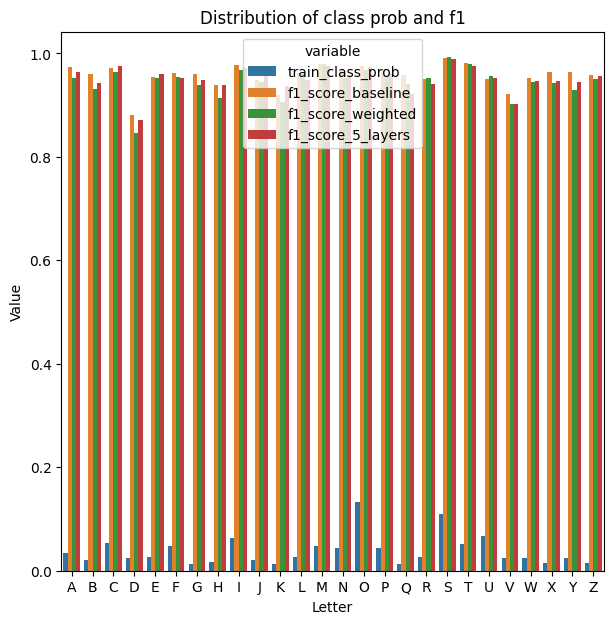

In [116]:
plot_distributions(report, 'f1_score_baseline', 'f1_score_weighted', 'f1_score_5_layers')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 700x700 with 0 Axes>

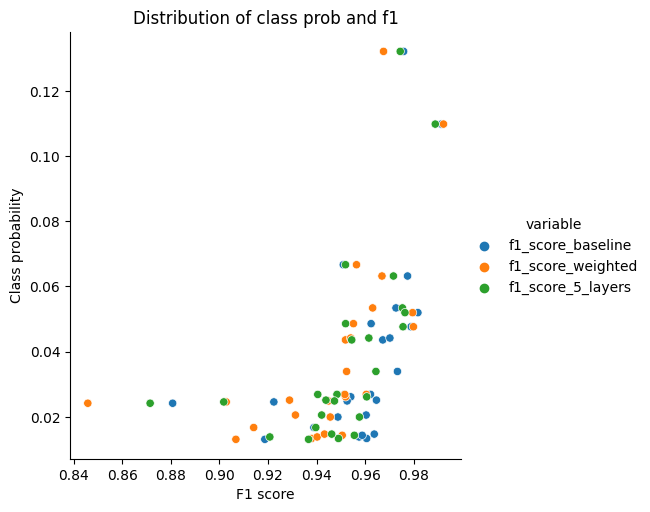

In [117]:
plot_f1_vs_class_prob(report, 'f1_score_baseline', 'f1_score_weighted', 'f1_score_5_layers')

### Random Oversampling

In [118]:
from imblearn.over_sampling import RandomOverSampler

train_rand_balanced_dataset = HandwritingsBalancedDataset(RandomOverSampler(), X_file_path=DATA_DIR / 'X_train.npy', y_file_path=DATA_DIR / 'y_train.npy',
                                            data_transform=normalize)

train_rand_balanced_loader = DataLoader(train_rand_balanced_dataset, num_workers=4,
                         batch_size=batch_size, shuffle=True)

In [119]:
fnn_checkpoint_dir = WRITING_DIR / 'fnn_4_layers_rand_balanced'

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=fnn_checkpoint_dir / 'best_results', filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

fnn = FNN(input_size=input_size, n_classes=n_classes, hidden_sizes=hidden_sizes)

trainer = pl.Trainer(max_epochs=max_epochs, default_root_dir=fnn_checkpoint_dir, fast_dev_run=True,
                     callbacks=[early_stopping, checkpoint_callback])

trainer.fit(fnn, train_rand_balanced_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /kaggle/working/fnn_4_layers_rand_balanced/best_results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassF1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [120]:
os.listdir(fnn_checkpoint_dir / 'best_results')

['last.ckpt', 'epoch=0-val_loss=0.24-train_loss=0.25.ckpt']

In [121]:
fnn_checkpoint_dir = WRITING_DIR / 'fnn_4_layers_rand_balanced'
fnn = FNN.load_from_checkpoint(fnn_checkpoint_dir / 'best_results/epoch=0-val_loss=0.24-train_loss=0.25.ckpt', input_size=input_size,
                               n_classes=n_classes, hidden_sizes=hidden_sizes)

trainer = pl.Trainer()
predictions = trainer.predict(fnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

Predicting: 0it [00:00, ?it/s]

              precision    recall  f1-score   support

           0       0.63      0.81      0.71       320
           1       0.69      0.66      0.68       194
           2       0.86      0.92      0.89       505
           3       0.83      0.63      0.72       228
           4       0.34      0.98      0.51       247
           5       0.88      0.67      0.76       459
           6       0.78      0.78      0.78       126
           7       0.87      0.65      0.74       158
           8       0.83      0.92      0.87       597
           9       0.46      0.72      0.56       188
          10       0.94      0.76      0.84       123
          11       0.96      0.50      0.66       254
          12       1.00      0.55      0.71       450
          13       0.86      0.89      0.87       412
          14       0.91      0.95      0.93      1249
          15       0.92      0.71      0.80       417
          16       0.80      0.72      0.76       130
          17       0.54    

In [183]:
fnn_checkpoint_dir = WRITING_DIR / 'fnn_4_layers_rand_balanced'
fnn = FNN.load_from_checkpoint(fnn_checkpoint_dir / 'best_results/epoch=0-val_loss=0.24-train_loss=0.25.ckpt', input_size=input_size,
                               n_classes=n_classes, hidden_sizes=hidden_sizes)
torch.save(fnn.state_dict(), 'fnn_5_layers_rand_balanced_model')

In [184]:
os.remove('fnn_4_layers_rand_balanced_model')

In [122]:
clf_report_rand_balanced = get_classification_report(subtest_labels, torch.cat(predictions).numpy())
report['f1_score_rand_balanced'] = clf_report_rand_balanced['f1_score']

We got worse result, but class inbalance is less

In [123]:
report['f1_score_rand_balanced'].min()

0.5079030558482613

In [124]:
print_summary(report, 'f1_score_rand_balanced')

Mean f1 score [f1_score_rand_balanced] = 0.775
Mean train class prob = 0.038
Classes with f1 score BELOW mean
    f1_score_rand_balanced  train_class_prob
A                0.707650          0.033910
B                0.677165          0.020520
D                0.718204          0.024146
E                0.507903          0.026110
F                0.763906          0.048589
H                0.743682          0.016684
J                0.560166          0.019912
L                0.661499          0.026865
M                0.711429          0.047636
Q                0.756098          0.013786
R                0.677563          0.026845
T                0.679947          0.051969
Z                0.729323          0.014296
Classes with probability BELOW mean
    f1_score_rand_balanced  train_class_prob
A                0.707650          0.033910
B                0.677165          0.020520
D                0.718204          0.024146
E                0.507903          0.026110
G               

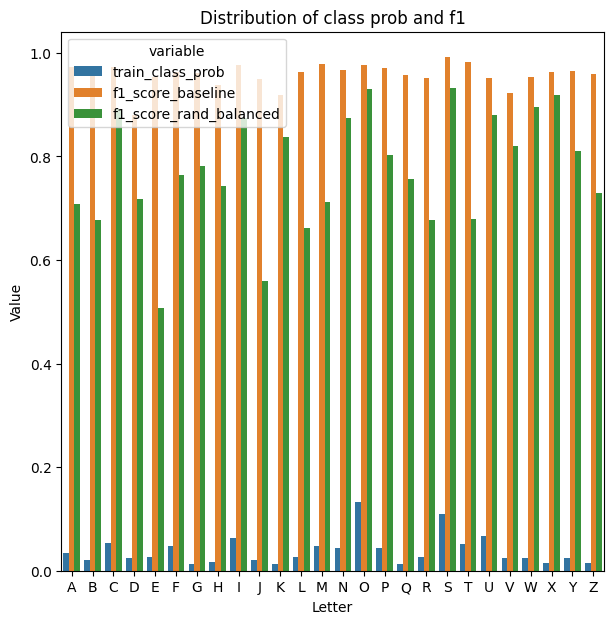

In [127]:
plot_distributions(report, 'f1_score_baseline', 'f1_score_rand_balanced')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 700x700 with 0 Axes>

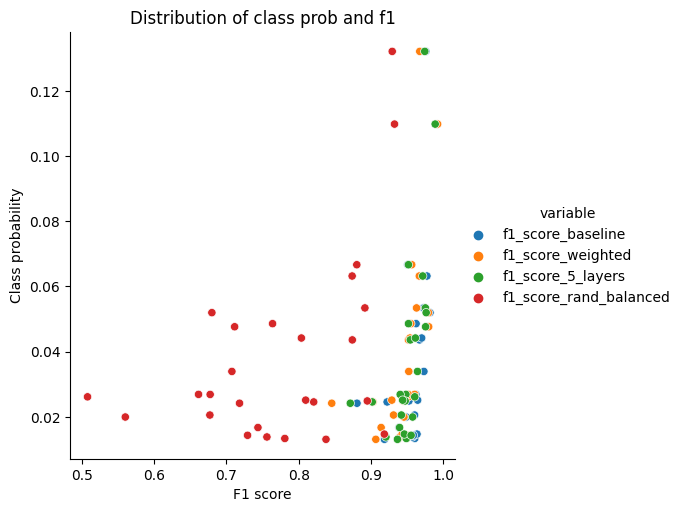

In [126]:
plot_f1_vs_class_prob(report, 'f1_score_baseline', 'f1_score_weighted', 'f1_score_5_layers', 'f1_score_rand_balanced')

### Create more complex model

In [128]:
class FNNReg(BaseFNN):
    
    def __init__(self, input_size, act_fn=F.relu, **kwargs):
        super().__init__(**kwargs)

        self.act_fn = act_fn
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.drop1 = nn.Dropout()
        self.fc3 = nn.Linear(512, 256)
        self.drop2 = nn.Dropout()
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, self.n_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.drop1(x)
        x = F.relu(self.fc3(x))
        x = self.drop2(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [143]:
train_rand_balanced_dataset = HandwritingsBalancedDataset(RandomOverSampler(), X_file_path=DATA_DIR / 'X_train.npy', y_file_path=DATA_DIR / 'y_train.npy',
                                            data_transform=normalize, sample_transform=ImgTransform(image_transform, color_channel=False))

train_rand_balanced_loader = DataLoader(train_rand_balanced_dataset, num_workers=4,
                         batch_size=batch_size, shuffle=True)

In [145]:
fnn_checkpoint_dir = WRITING_DIR / 'fnn_regularized'

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=fnn_checkpoint_dir / 'best_results', filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

fnn = FNNReg(input_size=input_size, n_classes=n_classes)

trainer = pl.Trainer(max_epochs=max_epochs, default_root_dir=fnn_checkpoint_dir, fast_dev_run=False,
                     callbacks=[early_stopping, checkpoint_callback])

trainer.fit(fnn, train_rand_balanced_loader, val_loader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [146]:
os.listdir(fnn_checkpoint_dir / 'best_results')

['last.ckpt',
 'epoch=4-val_loss=0.19-train_loss=0.22.ckpt',
 'last-v1.ckpt',
 'epoch=8-val_loss=0.28-train_loss=0.96.ckpt']

In [147]:
fnn_checkpoint_dir = WRITING_DIR / 'fnn_regularized'
fnn = FNNReg.load_from_checkpoint(fnn_checkpoint_dir / 'best_results/epoch=8-val_loss=0.28-train_loss=0.96.ckpt', input_size=input_size,
                               n_classes=n_classes)

trainer = pl.Trainer()
predictions = trainer.predict(fnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

Predicting: 0it [00:00, ?it/s]

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       320
           1       0.92      0.93      0.93       194
           2       0.93      0.97      0.95       505
           3       0.85      0.79      0.82       228
           4       0.94      0.93      0.93       247
           5       0.97      0.91      0.93       459
           6       0.80      0.94      0.87       126
           7       0.82      0.95      0.88       158
           8       0.98      0.91      0.94       597
           9       0.75      0.90      0.82       188
          10       0.90      0.93      0.92       123
          11       0.93      0.91      0.92       254
          12       0.95      0.90      0.92       450
          13       0.92      0.90      0.91       412
          14       0.96      0.97      0.97      1249
          15       0.94      0.94      0.94       417
          16       0.77      0.88      0.82       130
          17       0.92    

In [186]:
fnn_checkpoint_dir = WRITING_DIR / 'fnn_regularized'
fnn = FNNReg.load_from_checkpoint(fnn_checkpoint_dir / 'best_results/epoch=8-val_loss=0.28-train_loss=0.96.ckpt', input_size=input_size,
                               n_classes=n_classes)
torch.save(fnn, 'fnn_regularized_model')

In [148]:
clf_report_regularized = get_classification_report(subtest_labels, torch.cat(predictions).numpy())
report['f1_score_regularized'] = clf_report_regularized['f1_score']

In [149]:
print_summary(report, 'f1_score_regularized')

Mean f1 score [f1_score_regularized] = 0.909
Mean train class prob = 0.038
Classes with f1 score BELOW mean
    f1_score_regularized  train_class_prob
D              0.815490          0.024146
G              0.868613          0.013323
H              0.882353          0.016684
J              0.816425          0.019912
N              0.905521          0.043594
Q              0.821429          0.013786
R              0.899194          0.026845
V              0.902386          0.024543
W              0.900662          0.024847
Y              0.898969          0.025098
Z              0.821918          0.014296
Classes with probability BELOW mean
    f1_score_regularized  train_class_prob
A              0.937595          0.033910
B              0.925450          0.020520
D              0.815490          0.024146
E              0.934959          0.026110
G              0.868613          0.013323
H              0.882353          0.016684
J              0.816425          0.019912
K             

In [150]:
report['f1_score_regularized'].min()

0.815489749430524

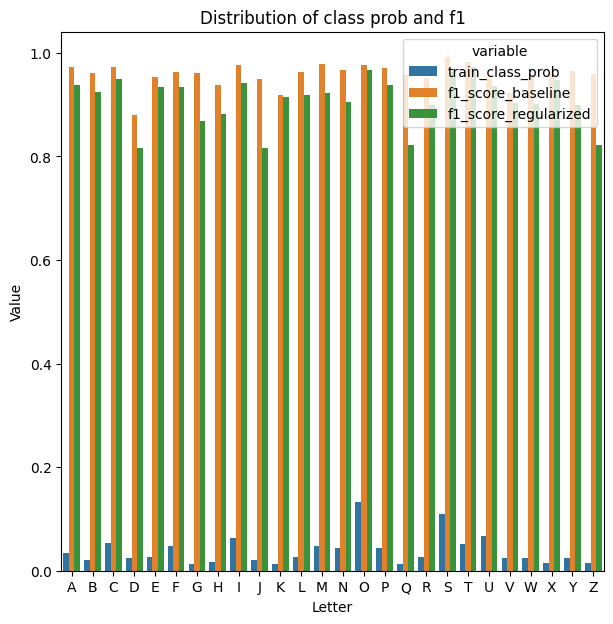

In [151]:
plot_distributions(report, 'f1_score_baseline', 'f1_score_regularized')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 700x700 with 0 Axes>

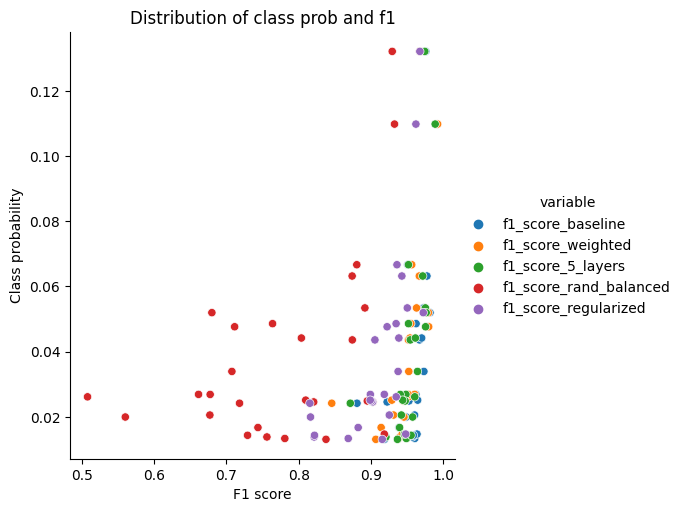

In [152]:
plot_f1_vs_class_prob(report, 'f1_score_baseline', 'f1_score_weighted', 'f1_score_5_layers', 'f1_score_rand_balanced', 'f1_score_regularized')

### Conclusions

The 'baseline' model turned out to be the best one and other versions were worse. Class imbalance affect predictions more in worse models, but with the baseline model they have quite good score. From two methods of balancing: class weights and random oversampling the 1st one was better (though not better from the baseline) and also trained faster. 